### Table of Contents

1. [Rabi Oscillations](#Rabi-Oscillations)
    1. [Simulating the Full Hamiltonian](#Simulating-the-Full-Hamiltonian)
    2. [With Rotating Wave Approximation](#With-Rotating-Wave-Approximation)
2. [Coherent State in a Harmonic Oscillator](#Coherent-State-in-a-Harmonic-Oscillator)
3. [Jaynes-Cummings Revival](#Jaynes-Cummings-Revival)
    1. [Definite Photon State](#Definite-Photon-State)
    2. [Coherent State](#Coherent-State)
    
The only addition to this notebook compared to the original is the `DEBUG=True` setting that prints all of the generated Cython code.

In [1]:
from cutiepy import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
cutiepy.codegen.DEBUG = True

# Rabi Oscillations

## Simulating the Full Hamiltonian

$\hat{H} = \hat{H}_0 + \Omega \sin((\omega_0+\Delta)t) \hat{\sigma}_x$

$\hat{H}_0 = \frac{\omega_0}{2}\hat{\sigma}_z$

In [2]:
initial_state = basis(2, 0)
initial_state

'{0}_{\\tiny N\\normalsize 2}'

In [3]:
ω0 = 1
Δ = 0.002
Ω = 0.005
ts = 2*np.pi/Ω*np.linspace(0,1,40)
H = ω0/2 * sigmaz() + Ω * sigmax() * sin((ω0+Δ)*t)
H

Add(Mul(0.005, sin(Mul(1.002, 't')), 'σ_x'), Mul(0.5, 'σ_z'))

In [4]:
res = sesolve(H, initial_state, ts)

In [5]:
σz_expect = expect(sigmaz(), res)

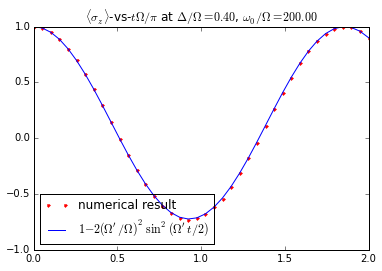

In [6]:
plt.plot(ts*Ω/np.pi, σz_expect, 'r.', label='numerical result')
Ωp = (Ω**2+Δ**2)**0.5
plt.plot(ts*Ω/np.pi, 1-(Ω/Ωp)**2*2*np.sin(Ωp*ts/2)**2, 'b-',
         label=r'$1-2(\Omega^\prime/\Omega)^2\sin^2(\Omega^\prime t/2)$')
plt.title(r'$\langle\sigma_z\rangle$-vs-$t\Omega/\pi$ at '
          r'$\Delta/\Omega=%.2f$, $\omega_0/\Omega=%.2f$'%(Δ/Ω, ω0/Ω))
plt.ylim(-1,1)
plt.legend(loc=3);

## With Rotating Wave Approximation

$\hat{H}^\prime = e^{i\hat{H}_0 t}\hat{H} e^{-i\hat{H}_0 t} \approx \frac{\Delta}{2} \hat{\sigma}_z + \frac{\Omega}{2} \hat{\sigma}_x$

In [7]:
Hp = Δ/2 * sigmaz() + Ω/2 * sigmax()
Hp

Add(Mul(0.001, 'σ_z'), Mul(0.0025, 'σ_x'))

In [8]:
res = sesolve(Hp, initial_state, ts)

In [9]:
σz_expect = expect(sigmaz(), res)

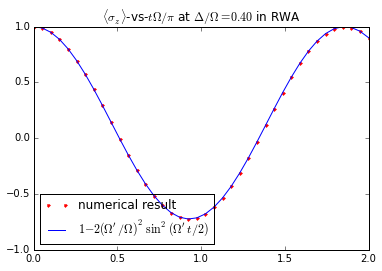

In [10]:
plt.plot(ts*Ω/np.pi, σz_expect, 'r.', label='numerical result')
Ωp = (Ω**2+Δ**2)**0.5
plt.plot(ts*Ω/np.pi, 1-(Ω/Ωp)**2*2*np.sin(Ωp*ts/2)**2, 'b-',
         label=r'$1-2(\Omega^\prime/\Omega)^2\sin^2(\Omega^\prime t/2)$')
plt.title(r'$\langle\sigma_z\rangle$-vs-$t\Omega/\pi$ at '
          r'$\Delta/\Omega=%.2f$ in RWA'%(Δ/Ω))
plt.ylim(-1,1)
plt.legend(loc=3);

# Coherent State in a Harmonic Oscillator

$|\alpha\rangle$ evolving under $\hat{H} = \hat{n}$

In [11]:
N_cutoff = 40
α = 2.5
initial_state = coherent(N_cutoff, α)
initial_state

'{\\tiny\\alpha\\normalsize 2.50}_{\\tiny N\\normalsize 40}'

In [12]:
H = num(N_cutoff)
H

'{n}_{40}'

In [13]:
ts = 2*np.pi*np.linspace(0,1,41)
res = sesolve(H, initial_state, ts)
a = destroy(N_cutoff)
a_expect = expect(a, res, keep_complex=True)

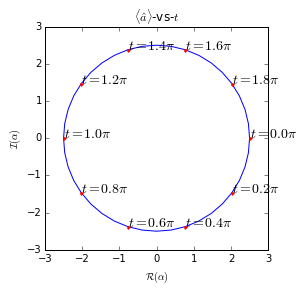

In [14]:
plt.figure(figsize=(4,4))
plt.plot(np.real(a_expect), np.imag(a_expect), 'b-')
for t, alpha in list(zip(ts,a_expect))[:40:4]:
    plt.plot(np.real(alpha), np.imag(alpha), 'r.')
    plt.text(np.real(alpha), np.imag(alpha), r'$t=%.1f\pi$'%(t/np.pi), fontsize=14)
plt.title(r'$\langle\hat{a}\rangle$-vs-$t$')
plt.ylabel(r'$\mathcal{I}(\alpha)$')
plt.xlabel(r'$\mathcal{R}(\alpha)$');

# Jaynes-Cummings Revival

$\hat{H} = \hat{H}_0 + \hat{H}^\prime$

$\hat{H}_0 = \omega \hat{n} + \omega \frac{1}{2} \hat{\sigma}_z$

$\hat{H}^\prime = g (\hat{\sigma}_+\hat{a} + \hat{\sigma}_-\hat{a}^\dagger)$

In [15]:
ω = 1
g = 0.1
ts = np.pi/g*np.linspace(0,1,150)
N_cutoff = 40
H0 = ω*(tensor(num(N_cutoff), identity(2)) + 0.5 * tensor(identity(N_cutoff), sigmaz()))
Hp = g*(tensor(destroy(N_cutoff),sigmap()) + tensor(create(N_cutoff), sigmam()))
H0 + Hp

Add(Mul(0.5, TensorProd('{I}_{40}', 'σ_z')), Mul(0.1, Add(TensorProd('{a^\\dagger}_{40}', 'σ_-'), TensorProd('{a}_{40}', 'σ_+'))), TensorProd('{n}_{40}', '{I}_{2}'))

## Definite Photon State

In [16]:
n = 3
n_p = tensor(basis(N_cutoff,n), basis(2,0))
np1_m = tensor(basis(N_cutoff,n+1), basis(2,1))
n_p

TensorProd('{3}_{\\tiny N\\normalsize 40}', '{0}_{\\tiny N\\normalsize 2}')

In [17]:
res = sesolve(H0 + Hp, n_p, ts)

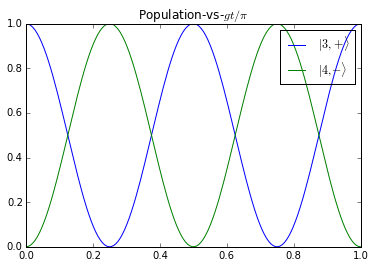

In [18]:
ovlps = overlap([n_p, np1_m], res)
plt.plot(ts*g/np.pi, np.abs(ovlps)**2)
plt.legend([r'$|%d,+\rangle$'%n, r'$|%d,-\rangle$'%(n+1)])
plt.title(r'Population-vs-$gt/\pi$');

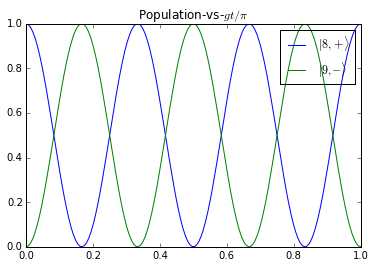

In [19]:
n = 8
n_p = tensor(basis(N_cutoff,n), basis(2,0))
np1_m = tensor(basis(N_cutoff,n+1), basis(2,1))
res = sesolve(H0 + Hp, n_p, ts)
ovlps = overlap([n_p, np1_m], res)
plt.plot(ts*g/np.pi, np.abs(ovlps)**2)
plt.legend([r'$|%d,+\rangle$'%n, r'$|%d,-\rangle$'%(n+1)])
plt.title(r'Population-vs-$gt/\pi$');

## Coherent State

In [20]:
alpha = 5
coh = tensor(coherent(N_cutoff, alpha), basis(2,0))
coh

TensorProd('{\\tiny\\alpha\\normalsize 5.00}_{\\tiny N\\normalsize 40}', '{0}_{\\tiny N\\normalsize 2}')

In [21]:
ts = 80/g*np.linspace(0,1,4000)
res = sesolve(H0 + Hp, coh, ts)
inversion = expect(tensor(identity(N_cutoff), sigmaz()), res)

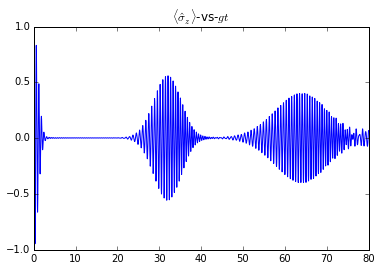

In [22]:
plt.plot(ts*g, inversion)
plt.title(r'$\langle \hat{\sigma}_z \rangle$-vs-$gt$');